In [1]:
##################################################
# CVsim.m - Cyclic voltammetry simulation
# Peter Attia
# Based on Bard and Faulkner, Appendix B
# EC mechanism
# Updated September 20, 2020
##################################################

import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import random
from IPython.display import clear_output


#scan variables
D        = .726E-5;   # [=] cm^2/s, O & R diffusion coefficient. Default = 1E-5
etai     = +0.5;   # [=] V, initial overpotential (relative to redox potential). Default = +0.2
etaf     = -0.5;   # [=] V, final overpotential (relative to redox potential). Default = -0.2
v        = .05;   # [=] V/s, sweep rate. Default = 1E-3
C_inital = 1e-3;    # [=] mol/L, initial concentration of O. Default = 1.0
TempK    = 298.15; # [=] K, temperature. Default = 298.15

## Fitting VARIABLES ##
n      = 1.0;    # [=] number of electrons transfered. Default = 1
alpha  = 0.51;    # [=] dimensionless charge-transfer coefficient. Default = 0.5
k0     = np.power(10,-1.3);   # [=] cm/s, electrochemical rate constant. Default = 1E-2
kc     = 1E-3;   # [=] 1/s, chemical rate constant. Default = 1E-3
area   =  .5*1 #cm^2     
OCP    = 0 #v

## PHYSICAL CONSTANTS ##
Faraday = 96485;   # [=] C/mol, Faraday's constant
R_ideal = 8.3145;  # [=] J/mol-K, ideal gas constant
f       = Faraday/(R_ideal*TempK); # [=] 1/V, normalized Faraday's constant at room temperature

## SIMULATION VARIABLES ##
L      = 500;    # [=] number of iterations per t_k (pg 790). Default = 500
DM     = 0.45;   # [=] model diffusion coefficient (pg 788). Default = 0.45

etai   -= OCP;   # [=] V, initial overpotential (relative to redox potential). Default = +0.2
etaf   -= OCP;  # [=] V, final overpotential (relative to redox potential). Default = -0.2


 

In [2]:
#cotrell equation for disk ultra micro electrode
Dcooh= 5.4e-6 #cm^2/s
radius_um = [5,8,10] #um
radius = np.array( radius_um)*1e-4 #cm
Ip= 4*n*Faraday* Dcooh *10*C_inital/1000* radius 
print('Ip = ',Ip*1e9, 'nA')

Ip =  [10.42038  16.672608 20.84076 ] nA


74.14829659318633 mV


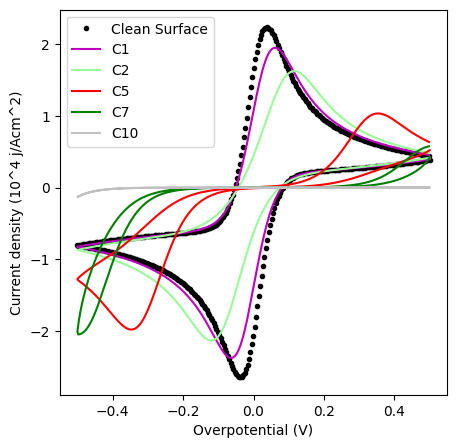

In [3]:
def SimulateCurve(gap,area,OCP, pinholes =.1):
  ## DERIVED CONSTANTS ##
  C = C_inital / 1000           # Convert C from mol/L to mol/cm3
  tk  = 2*(etai-etaf)/v;    # [=] s, characteristic exp. time (pg 790). In this case, total time of fwd and rev scans
  Dt  = tk/L;               # [=] s, delta time (Eqn B.1.10, pg 790)
  Dx  = np.sqrt(D*Dt/DM);      # [=] cm, delta x (Eqn B.1.13, pg 791)
  nBoxs   = int(np.ceil(4.2*L**0.5)+5);  # number of boxes (pg 792-793). If L~200, j=65

  ## REVERSIBILITY PARAMETERS ##
  ktk    = kc*tk              # dimensionless kinetic parameter (Eqn B.3.7, pg 797)
  km     = ktk/L              # normalized dimensionless kinetic parameter (see bottom of pg 797)
  Lambda = k0/(D*f*v)**0.5     # dimensionless reversibility parameter (Eqn 6.4.4, pg. 236-239)
  
  k = np.linspace( 0,L,L)                # time index vector
  t = Dt * k             # time vector
  eta1 = etai - v*t      # overpotential vector, negative scan
  eta2 = etaf + v*t      # overpotential vector, positive scan
  eta = np.concatenate([eta1[eta1>etaf] ,eta2[eta2<=etai],eta1[eta1>etaf] ,eta2[eta2<=etai]]) # overpotential scan, both directions
  Enorm = eta*f          # normalized overpotential
  kf = k0*np.exp(  -alpha *n*Enorm)*gap # [=] cm/s, fwd rate constant (pg 799)
  kb = k0*np.exp((1-alpha)*n*Enorm) *gap# [=] cm/s, rev rate constant (pg 799)
  
  kfclean = k0*np.exp(  -alpha *n*Enorm) # [=] cm/s, fwd rate constant (pg 799)
  kbclean = k0*np.exp((1-alpha)*n*Enorm)# [=] cm/s, rev rate constant (pg 799)

  O = C*np.ones((2*L,nBoxs)) # [=] mol/cm^3, concentration of O
  R = np.zeros((2*L,nBoxs) ) # [=] mol/cm^3, concentration of R
  JO = np.zeros((2*L)) # [=] mol/cm^2-s, flux of O at the surface

  CO = np.zeros((2*L)) # [=] mol/cm^2-s, c of O at the surface
  CR = np.zeros((2*L)) # [=] mol/cm^2-s, c of O at the surface

  for i_time in range(0,2*L-1):
      # Update bulk concentrations of O and R
      for i_dist in range( 1,int(nBoxs)-1):
          O[i_time+1,i_dist] = O[i_time,i_dist] + DM*(O[i_time,i_dist+1]+O[i_time,i_dist-1]-2*O[i_time,i_dist])
          R[i_time+1,i_dist] = R[i_time,i_dist] + DM*(R[i_time,i_dist+1]+R[i_time,i_dist-1]-2*R[i_time,i_dist]) - km * R[i_time,i_dist]


      # flux assuming that the surface can be split into two areas, one with the film and one without
      # the total flux from the surface adjacent solution is then the sum of the fluxes from each area
      # this is unlikely to model a surface with a lot of different species on the surface, which should
      #give a general broading of the peak
      if pinholes != 0:
        cleanO = O[i_time+1,1]*pinholes
        cleanR = R[i_time+1,1]*pinholes
        dirtyO= O[i_time+1,1]*(1-pinholes)
        dirtyR=R[i_time+1,1]*(1-pinholes)
        dirtyJ= ( kf[i_time+1]*dirtyO - kb[i_time+1]*dirtyR ) / (1 + Dx/D*(kf[i_time+1] + kb[i_time+1]) )
        cleanJ= ( kfclean[i_time+1]*cleanO - kbclean[i_time+1]*cleanR ) / (1 + Dx/D*(kfclean[i_time+1] + kbclean[i_time+1]) )
        JO[i_time+1] = dirtyJ+cleanJ
      
      #flux equation without the pinhole approximation
      else:
        JO[i_time+1]   = ( kf[i_time+1]*O[i_time+1,1] - kb[i_time+1]*R[i_time+1,1] ) / (1 + Dx/D*(kf[i_time+1] + kb[i_time+1]) )
      
      


      # Update surface concentrations
      O[i_time+1,0] = O[i_time+1,1] - JO[i_time+1]*Dx/D
      CO[i_time+1]  = R[i_time+1,1]
      R[i_time+1,0] = R[i_time+1,1] + JO[i_time+1]*Dx/D - km*R[i_time+1,0]
      CR[i_time+1]  = O[i_time+1,1]


  # Calculate current density, Z, from flux of O
  Z = -n*Faraday*JO * 1000; # [=] A/cm^2 -> mA/cm^2, current density

  ## PLOT RESULTS ##
  # Sometimes length(eta) = length(Z) + 1. If this is the case, truncate last value
  if len(eta) > len(Z):
      eta = eta[1:-1]
  return eta[int(len(Z)/2):]+OCP,Z[int(len(Z)/2):]*area

eta,Z=SimulateCurve(1,area,0)

maxV=eta[ np.argmax(Z)]
minV=eta[ np.argmin(Z)]
print((maxV-minV)*1000,"mV")

fig=plt.figure(figsize=(5,5))
plt.plot(eta  ,Z/area*20,'k.',label='Clean Surface' )
#plt.plot( V,I,'k', label='Measured')    
colors=['m','palegreen','r','g','silver']
cc=0
for i in [1,2,5,7,10]:
  eta2,Z2=SimulateCurve( np.exp(-1.5*(i+1)),area, 0,pinholes=0)
  plt.plot(eta2,Z2/area*20, label =f'C{i}',color=colors[cc])
  cc+=1
 
plt.xlabel('Overpotential (V)')
plt.ylabel('Current density (10^4 j/Acm^2)')
plt.legend()
plt.show()

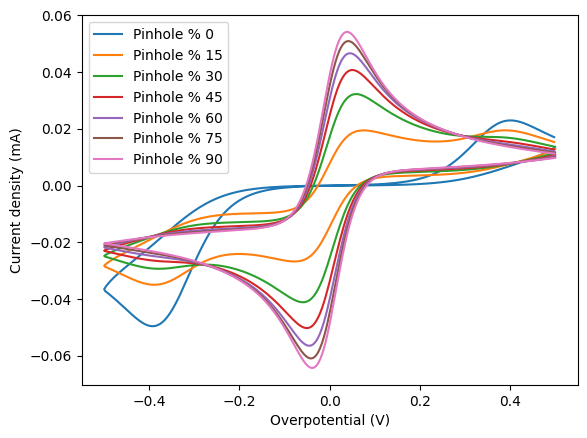

In [4]:

for i in range(0,100,15):
    eta,Z=SimulateCurve(np.exp(-.9*11),area,OCP,i/100.0)

    plt.plot(eta  ,Z,label=f'Pinhole % {i}' )
 
plt.xlabel('Overpotential (V)')
plt.ylabel('Current density (mA)')
plt.legend()
plt.show()

In [5]:

def Gradient2ndOrder(f,dx):
  f = np.asanyarray(f)
  N = f.ndim  # number of dimensions
  axes = tuple(range(N))

  len_axes = len(axes)
  dx = [dx] * len_axes
  outvals = []

  # create slice objects --- initially all are [:, :, ..., :]
  slice1 = [slice(None)]*N
  slice2 = [slice(None)]*N
  slice3 = [slice(None)]*N
  slice4 = [slice(None)]*N

  for axis, ax_dx in zip(axes, dx):

      # result allocation
      out = np.empty_like(f, dtype=float)

      # Numerical differentiation: 2nd order interior
      slice1[axis] = slice(1, -1)
      slice2[axis] = slice(None, -2)
      slice3[axis] = slice(1, -1)
      slice4[axis] = slice(2, None)
      out[tuple(slice1)] = (f[tuple(slice4)] + f[tuple(slice2)] - 2*f[tuple(slice1)]) / (ax_dx)


      out = GradientEdge1D(out, axis, f, ax_dx, slice1,slice2,slice3,slice4)
      outvals.append(out)

      # reset the slice object in this dimension to ":"
      slice1[axis] = slice(None)
      slice2[axis] = slice(None)
      slice3[axis] = slice(None)
      slice4[axis] = slice(None)
  return outvals

def GradientEdge1D(out, axis, f, dx_0, slice1,slice2,slice3,slice4):
      slice1[axis] = 1
      slice2[axis] = 2
      slice3[axis] = 1

      d1 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
      slice1[axis] = 0
      slice2[axis] = 1
      slice3[axis] = 0

      d2 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
      out[tuple(slice1)]=-1*(d1-d2)/dx_0

      slice1[axis] = -2
      slice2[axis] = -2
      slice3[axis] = -3

      d1 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0

      slice1[axis] = -1
      slice2[axis] = -1
      slice3[axis] = -2

      d2 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0

      out[tuple(slice1)]=(d1-d2)/dx_0
      return out

In [6]:
 

EWidth_um   = 3       # [=] um  width of electrode
ELength_um  = 10      # [=] um  length of the electrode
gridSize_um = 100     # [=] um  max dimension that contains the electrode.
Dx_um     = .2    # [=] um Grid step


In [7]:
EWidth    = EWidth_um   *1e-4     # convert to cm
gridSize  = gridSize_um *1e-4     # convert to cm
ELength   = ELength_um  *1e-4     # convert to cm
Dx        = Dx_um       *1e-4     # convert to cm
C         = C_inital    / 1000    # Convert C from mol/L to mol/cm3

## DERIVED CONSTANTS ##
tk       = 2*(etai-etaf)/v            # [=] s, characteristic exp. time (pg 790). In this case, total time of fwd and rev scans
Dt       = Dx*Dx*DM/D                 # [=] s, delta time
L        = int(np.ceil(tk/Dt ))       # [=] number of time steps
numBoxs  = int(np.ceil(gridSize/Dx))  # number of boxes (pg 792-793). If L~200, j=65

## REVERSIBILITY PARAMETERS ##
normedF  = Faraday/(R_ideal*TempK) # [=] 1/V, normalized Faraday's constant at room temperature
ktk    = kc*tk                     # dimensionless kinetic parameter (Eqn B.3.7, pg 797)
km     = ktk/L                     # normalized dimensionless kinetic parameter (see bottom of pg 797)
Lambda = k0/(D*normedF*v)**0.5     # dimensionless reversibility parameter (Eqn 6.4.4, pg. 236-239)

## CHEMICAL REVERSIBILITY WARNING ##
if km>0.1:
    print('k_c*t_k/l equals ' + str(km) +', which exceeds the upper limit of 0.1 (see B&F, pg 797)')

print(f'Dx: {Dx*1e4:.4f} um')
print(f'timeSteps: { L } of {Dt} s')
print(f'Number of grid cells: {numBoxs}')

Dx: 0.2000 um
timeSteps: 1613334 of 2.479338842975207e-05 s
Number of grid cells: 500


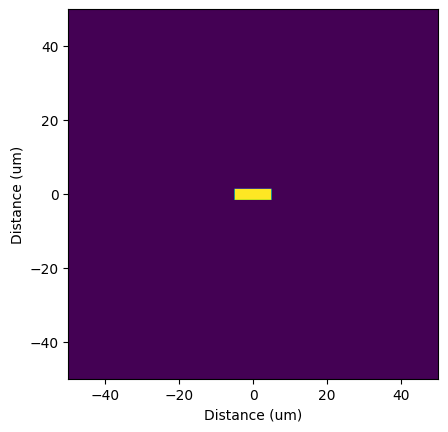

In [8]:
mask     = np.zeros((numBoxs,numBoxs))
m1=int(np.ceil(numBoxs/2-EWidth/2/Dx))
m2=int(np.ceil(numBoxs/2+EWidth/2/Dx))

m1x=int(np.ceil(numBoxs/2-ELength/2/Dx))
m2x=int(np.ceil(numBoxs/2+ELength/2/Dx))
for i in range(m1,m2):
    mask[i,m1x:m2x]=1

#for i in range(m1,m2):
#    mask[m1x:m2x,i]=0

plt.imshow(mask, extent=[gridSize/-2*1e4,gridSize/2*1e4,gridSize/-2*1e4,gridSize/2*1e4])
plt.xlabel('Distance (um)')
plt.ylabel('Distance (um)')
plt.show()

In [ ]:
import torch
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from IPython.display import clear_output

## INDEPENDENT VARIABLES ##
C        = 5e-3;    # [=] mol/L, initial concentration of O. Default = 1.0
D        = .726E-5;   # [=] cm^2/s, O & R diffusion coefficient. Default = 1E-5
etai     = +0.4;   # [=] V, initial overpotential (relative to redox potential). Default = +0.2
etaf     = -0.4;   # [=] V, final overpotential (relative to redox potential). Default = -0.2
v        = .2;   # [=] V/s, sweep rate. Default = 1E-3
n        = 1.0;    # [=] number of electrons transfered. Default = 1
alpha    = 0.51;    # [=] dimensionless charge-transfer coefficient. Default = 0.5
k0       = 1e-2 #np.power(10,-1.3);   # [=] cm/s, electrochemical rate constant. Default = 1E-2
kc       = 1E-3;   # [=] 1/s, chemical rate constant. Default = 1E-3
T        = 298.15; # [=] K, temperature. Default = 298.15
EWidth   = 3       # [=] um  width of electrode
ELength  = 10      # [=] um  length of the electrode
gridSize = 100     # [=] um  max dimension that contains the electrode.

## PHYSICAL CONSTANTS ##
F        = 96485;   # [=] C/mol, Faraday's constant
R        = 8.3145;  # [=] J/mol-K, ideal gas constant
normedF  = F/(R*T); # [=] 1/V, normalized Faraday's constant at room temperature

## SIMULATION VARIABLES ##
Dx     = .1    # [=] um Grid step
DM     = 0.45   # [=] model diffusion coefficient (pg 788). Default = 0.45

C  = C / 1000            # Convert C from mol/L to mol/cm3
Dx = Dx * 1e-4           # convert to cm
EWidth = EWidth *1e-4    # convert to cm
gridSize = gridSize*1e-4 # convert to cm
ELength = ELength *1e-4     # convert to cm

In [10]:
## DERIVED CONSTANTS ##
tk       = 2*(etai-etaf)/v       # [=] s, characteristic exp. time (pg 790). In this case, total time of fwd and rev scans
Dt       = Dx*Dx*DM/D            # [=] s, delta time
L        = int(np.ceil(tk/Dt ))  # [=] number of time steps
numBoxs  = int(np.ceil(gridSize/Dx))  # number of boxes (pg 792-793). If L~200, j=65

## REVERSIBILITY PARAMETERS ##
ktk    = kc*tk                   # dimensionless kinetic parameter (Eqn B.3.7, pg 797)
km     = ktk/L                   # normalized dimensionless kinetic parameter (see bottom of pg 797)
Lambda = k0/(D*normedF*v)**0.5   # dimensionless reversibility parameter (Eqn 6.4.4, pg. 236-239)

## CHEMICAL REVERSIBILITY WARNING ##
if km>0.1:
    print('k_c*t_k/l equals ' + str(km) +', which exceeds the upper limit of 0.1 (see B&F, pg 797)')

print(f'Dx: {Dx*1e4:.4f} um')
print(f'timeSteps: { L } of {Dt} s')
print(f'Number of grid cells: {numBoxs}')

Dx: 0.1000 um
timeSteps: 5808000 of 1.3774104683195597e-06 s
Number of grid cells: 1000


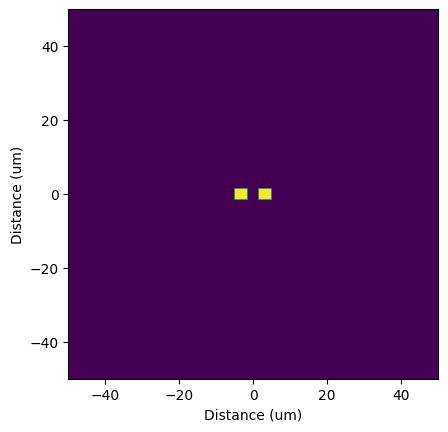

In [11]:
mask     = np.zeros((numBoxs,numBoxs))
m1=int(np.ceil(numBoxs/2-EWidth/2/Dx))
m2=int(np.ceil(numBoxs/2+EWidth/2/Dx))

m1x=int(np.ceil(numBoxs/2-ELength/2/Dx))
m2x=int(np.ceil(numBoxs/2+ELength/2/Dx))
for i in range(m1,m2):
    mask[i,m1x:m2x]=1

for i in range(m1,m2):
    mask[m1x:m2x,i]=0

plt.imshow(mask, extent=[gridSize/-2*1e4,gridSize/2*1e4,gridSize/-2*1e4,gridSize/2*1e4])
plt.xlabel('Distance (um)')
plt.ylabel('Distance (um)')
plt.show()

In [12]:

def Gradient2ndOrder(f,dx):
  f = np.asanyarray(f)
  N = f.ndim  # number of dimensions
  axes = tuple(range(N))

  len_axes = len(axes)
  dx = [dx] * len_axes
  outvals = []

  # create slice objects --- initially all are [:, :, ..., :]
  slice1 = [slice(None)]*N
  slice2 = [slice(None)]*N
  slice3 = [slice(None)]*N
  slice4 = [slice(None)]*N

  for axis, ax_dx in zip(axes, dx):

      # result allocation
      out = np.empty_like(f, dtype=float)

      # Numerical differentiation: 2nd order interior
      slice1[axis] = slice(1, -1)
      slice2[axis] = slice(None, -2)
      slice3[axis] = slice(1, -1)
      slice4[axis] = slice(2, None)
      out[tuple(slice1)] = (f[tuple(slice4)] + f[tuple(slice2)] - 2*f[tuple(slice1)]) / (ax_dx)


      out = GradientEdge1D(out, axis, f, ax_dx, slice1,slice2,slice3,slice4)
      outvals.append(out)

      # reset the slice object in this dimension to ":"
      slice1[axis] = slice(None)
      slice2[axis] = slice(None)
      slice3[axis] = slice(None)
      slice4[axis] = slice(None)
  return outvals

def GradientEdge1D(out, axis, f, dx_0, slice1,slice2,slice3,slice4):
      slice1[axis] = 1
      slice2[axis] = 2
      slice3[axis] = 1

      d1 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
      slice1[axis] = 0
      slice2[axis] = 1
      slice3[axis] = 0

      d2 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
      out[tuple(slice1)]=-1*(d1-d2)/dx_0

      slice1[axis] = -2
      slice2[axis] = -2
      slice3[axis] = -3

      d1 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0

      slice1[axis] = -1
      slice2[axis] = -1
      slice3[axis] = -2

      d2 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0

      out[tuple(slice1)]=(d1-d2)/dx_0
      return out

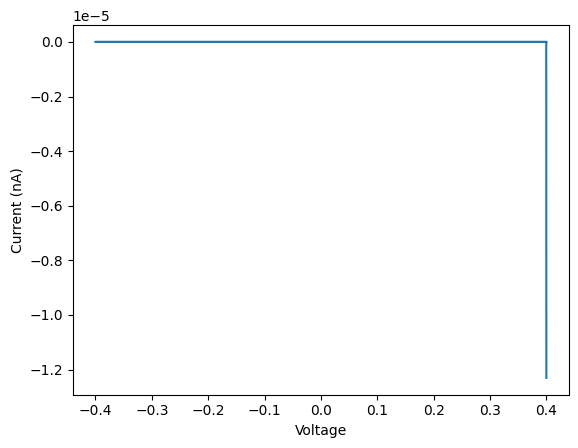

In [ ]:
#def SimulateCurve3D(gap):
gap=1
t = Dt * np.linspace( 0,L,L)             # time vector
eta1 = etai - v*t      # overpotential vector, negative scan
eta2 = etaf + v*t      # overpotential vector, positive scan
eta = np.concatenate([eta1[eta1>etaf] ,eta2[eta2<=etai]])#,eta1[eta1>etaf] ,eta2[eta2<=etai]]) # overpotential scan, both directions
Enorm = eta*normedF          # normalized overpotential
kf = k0*np.exp(  -alpha *n*Enorm)*gap # [=] cm/s, fwd rate constant (pg 799)
kb = k0*np.exp((1-alpha)*n*Enorm) *gap# [=] cm/s, rev rate constant (pg 799)
kRateNorm = (1 + Dx/D*(kf + kb) )

O = C*np.ones((numBoxs,numBoxs,int(numBoxs/2))) # [=] mol/cm^3, concentration of O
R =  np.zeros((numBoxs,numBoxs,int(numBoxs/2))) # [=] mol/cm^3, concentration of R

IO = np.zeros((len(eta))) # [=] mol/cm^2-s, flux of O at the surface

for i_time in range(0,len(eta)):
    gradients = Gradient2ndOrder(O,1)
    O = O + DM*(gradients[0]+gradients[1]+gradients[2])
    gradients=0
    gradients = Gradient2ndOrder(R,1)
    R = R + DM*(gradients[0]+gradients[1]+gradients[2]) - km * R
    gradients=0
    # Update flux
    J= (( kf[i_time]*O[:,:,1] - kb[i_time]*R[:,:,1] ) / kRateNorm[i_time])*mask

    # Update surface concentrations
    O[:,:,0] = O[:,:,1] - J*Dx/D
    R[:,:,0] = R[:,:,1] + J*Dx/D - km*R[:,:,0]
    IO[i_time] = np.sum(J)*Dx*Dx

    if i_time%1000==0:
        clear_output(wait=False)
        plt.plot(eta,n*F*IO*-1e9)
        plt.xlabel('Voltage')
        plt.ylabel('Current (nA)')
        plt.show()

plt.plot(eta,n*F*IO*-1e9)
plt.xlabel('Voltage')
plt.ylabel('Current (nA)')
plt.show()

In [ ]:

#def SimulateCurve3D(gap):
gap=1
t = Dt * np.linspace( 0,L,L)             # time vector
eta1 = etai - v*t      # overpotential vector, negative scan
eta2 = etaf + v*t      # overpotential vector, positive scan
eta = np.concatenate([eta1[eta1>etaf] ,eta2[eta2<=etai]])#,eta1[eta1>etaf] ,eta2[eta2<=etai]]) # overpotential scan, both directions
Enorm = eta*normedF          # normalized overpotential
kf = k0*np.exp(  -alpha *n*Enorm)*gap # [=] cm/s, fwd rate constant (pg 799)
kb = k0*np.exp((1-alpha)*n*Enorm) *gap# [=] cm/s, rev rate constant (pg 799)
kRateNorm = (1 + Dx/D*(kf + kb) )
 

# Assuming the following functions and constants are predefined:
# DM, km, kf, kb, kRateNorm, mask, Dx, D, eta, numBoxs, Faraday, n

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def gradient_2nd_order(arr, dx):
    grad_x = (torch.roll(arr, -1, dims=0) - 2 * arr + torch.roll(arr, 1, dims=0)) / dx**2
    grad_y = (torch.roll(arr, -1, dims=1) - 2 * arr + torch.roll(arr, 1, dims=1)) / dx**2
    grad_z = (torch.roll(arr, -1, dims=2) - 2 * arr + torch.roll(arr, 1, dims=2)) / dx**2
    return grad_x, grad_y, grad_z 

# Initialize tensors for concentration of O and R on GPU
O = torch.tensor(C*np.ones((numBoxs,numBoxs,int(numBoxs/2))), dtype=torch.float32, device=device)  # [=] mol/cm^3
R = torch.zeros((numBoxs, numBoxs, int(numBoxs/2)), dtype=torch.float32, device=device)            # [=] mol/cm^3

IO = torch.zeros(len(eta), dtype=torch.float32, device=device)  # [=] mol/cm^2-s

# Move constants to GPU if needed
mask = torch.tensor(mask, device=device)
kf = torch.tensor(kf, device=device)
kb = torch.tensor(kb, device=device)
kRateNorm = torch.tensor(kRateNorm, device=device)

# Loop over time
for i_time in range(len(eta)):
    # Compute gradients using PyTorch on GPU
    grad_Ox, grad_Oy, grad_Oz = gradient_2nd_order(O, 1)
    O = O + DM * (grad_Ox + grad_Oy + grad_Oz)

    grad_Rx, grad_Ry, grad_Rz = gradient_2nd_order(R, 1)
    R = R + DM * (grad_Rx + grad_Ry + grad_Rz) - km * R

    # Update flux
    J = ((kf[i_time] * O[:, :, 1] - kb[i_time] * R[:, :, 1]) / kRateNorm[i_time]) * mask

    # Update surface concentrations
    O[:, :, 0] = O[:, :, 1] - J * Dx / D
    R[:, :, 0] = R[:, :, 1] + J * Dx / D - km * R[:, :, 0]
    IO[i_time] = torch.sum(J) * Dx * Dx

    # Display progress and results
    if i_time % 100 == 0:
        print('.', end='')
    if i_time % 1000 == 0:
        clear_output(wait=True)
        _, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].plot(eta, n * Faraday * IO.cpu().numpy() * -1e9)
        ax[1].imshow(O[:, :, 1].cpu().numpy())
        ax[2].imshow(O[int(numBoxs / 2), :, :].cpu().numpy())
        plt.show()

In [ ]:
# gap=1
# t = Dt * np.linspace( 0,L,L)             # time vector
# eta1 = etai - v*t      # overpotential vector, negative scan
# eta2 = etaf + v*t      # overpotential vector, positive scan
# eta = np.concatenate([eta1[eta1>etaf] ,eta2[eta2<=etai]])#,eta1[eta1>etaf] ,eta2[eta2<=etai]]) # overpotential scan, both directions
# Enorm = eta*normedF          # normalized overpotential
# kf = k0*np.exp(  -alpha *n*Enorm)*gap # [=] cm/s, fwd rate constant (pg 799)
# kb = k0*np.exp((1-alpha)*n*Enorm) *gap# [=] cm/s, rev rate constant (pg 799)
# kRateNorm = (1 + Dx/D*(kf + kb) )

# O = C*np.ones((numBoxs,numBoxs,int(numBoxs/2))) # [=] mol/cm^3, concentration of O
# R =  np.zeros((numBoxs,numBoxs,int(numBoxs/2))) # [=] mol/cm^3, concentration of R

# IO = np.zeros((len(eta))) # [=] mol/cm^2-s, flux of O at the surface

# for i_time in range(0,len(eta)):
#     gradients = Gradient2ndOrder(O,1)
#     O = O + DM*(gradients[0]+gradients[1]+gradients[2])
#     gradients = Gradient2ndOrder(R,1)
#     R = R + DM*(gradients[0]+gradients[1]+gradients[2]) - km * R

#     # Update flux
#     J= (( kf[i_time]*O[:,:,1] - kb[i_time]*R[:,:,1] ) / kRateNorm[i_time])*mask

#     # Update surface concentrations
#     O[:,:,0] = O[:,:,1] - J*Dx/D
#     R[:,:,0] = R[:,:,1] + J*Dx/D - km*R[:,:,0]
#     IO[i_time] = np.sum(J)*Dx*Dx

#     if i_time%100==0:
#         print('.',end='')
#     if i_time%1000==0:
#         clear_output(wait=True)
#         _,ax=plt.subplots(1,3,figsize=(12,4))
#         ax[0].plot(eta,n*Faraday*IO*-1e9)
#         ax[1].imshow(O[:,:,1] )
#         ax[2].imshow(O[ int(numBoxs/2),:,:] )
#         plt.show()
        

# plt.plot(eta,n*Faraday*IO*-1e9)
# plt.xlabel('Voltage')
# plt.ylabel('Current (nA)')
# plt.show()